# Importing libraries and Data loading

In [1]:
import pandas as pd
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import nltk
import re
import string
import spacy
nlp = spacy.load('en_core_web_sm')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [6]:
movies_data=pd.read_csv('data/all_movies.csv')
fox_news_data=pd.read_csv('data/fox_news.csv')
twitter_data=pd.read_csv('data/twitter.csv')
movies_data=movies_data[['movie_id','movie_name','batch_id','text','majority_answer']]
fox_news_data=fox_news_data[['comment','label']]
twitter_data=twitter_data[['tweet','label']]
print(movies_data.head())
print(fox_news_data.head())
print(twitter_data.head())

                   movie_id         movie_name    batch_id  \
0  AmericanHistoryX(1998)_1  AmerricanHistoryX  1566624979   
1  AmericanHistoryX(1998)_2  AmerricanHistoryX  1566624979   
2  AmericanHistoryX(1998)_3  AmerricanHistoryX  1566624979   
3  AmericanHistoryX(1998)_4  AmerricanHistoryX  1566624979   
4  AmericanHistoryX(1998)_5  AmerricanHistoryX  1566624979   

                                                text  majority_answer  
0                                             Derek.                0  
1                    What the fuck are you thinking?                1  
2  There's a black guy outside breaking into your...                0  
3                        How long has he been there?                0  
4                                      I don't know.                0  
                                             comment  label
0                          Merkel would never say NO      2
1  Expect more and more women to be asking .. "wh...      2
2  Groping peop

# Data Exploration

In [3]:
print(movies_data.movie_name.value_counts())
print(twitter_data.label.value_counts())
print(fox_news_data.label.value_counts())
print(len(movies_data))
print(len(twitter_data))
print(len(fox_news_data))
print(len(movies_data)+len(twitter_data)+len(fox_news_data))

TheWolfofWallStreet    3063
Django_Unchained       1747
BlacKkKlansman         1645
Pulp_Fiction           1622
AmerricanHistoryX      1565
South_Park             1046
Name: movie_name, dtype: int64
1    18967
0     4099
2     1406
Name: label, dtype: int64
0    1083
2     430
Name: label, dtype: int64
10688
24472
1513
36673


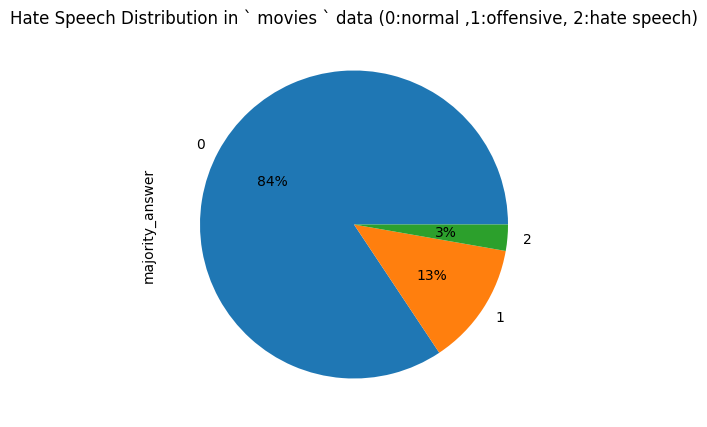

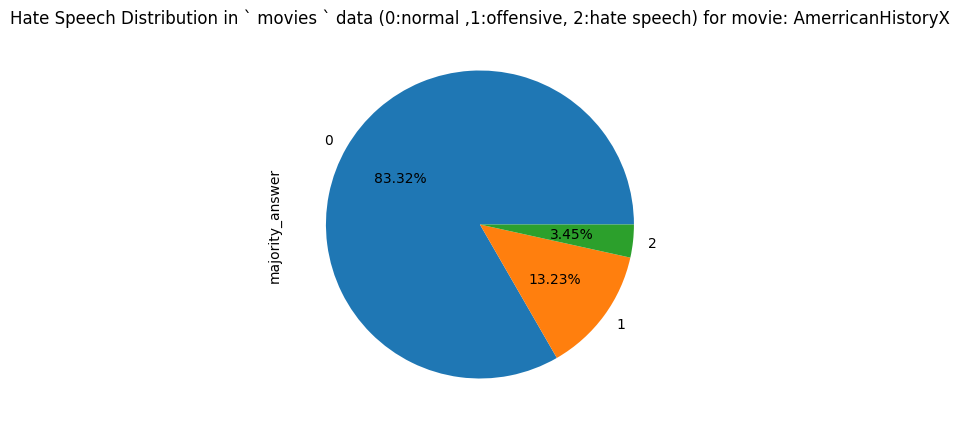

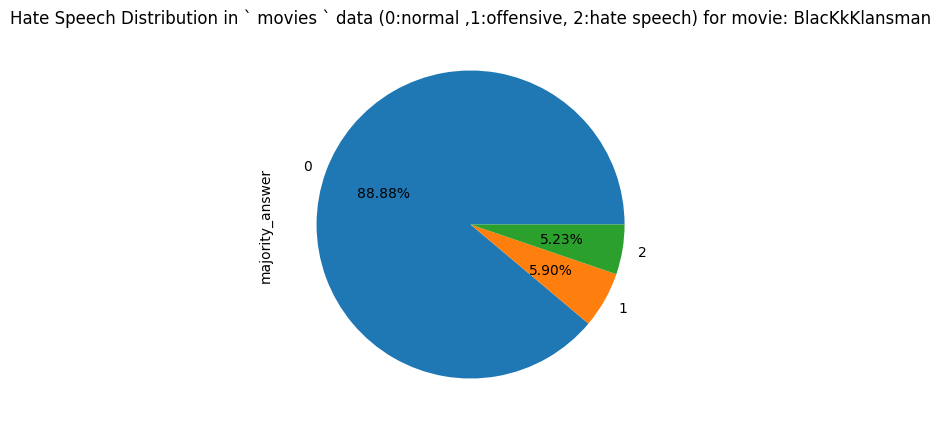

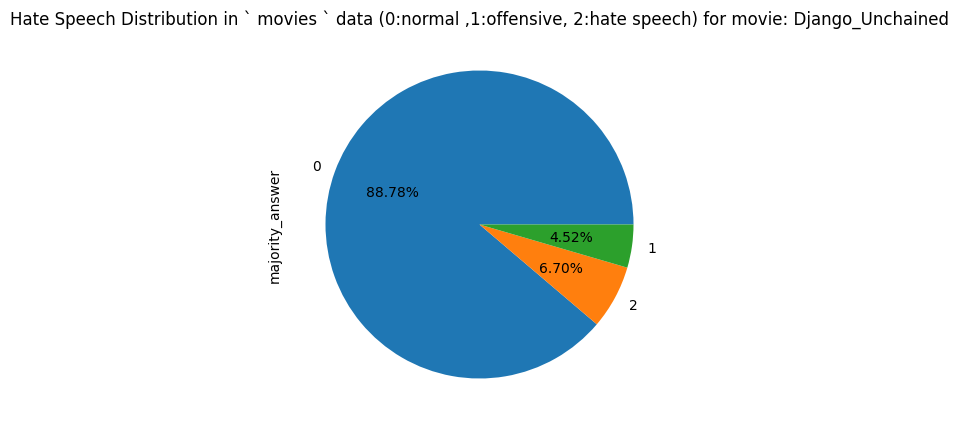

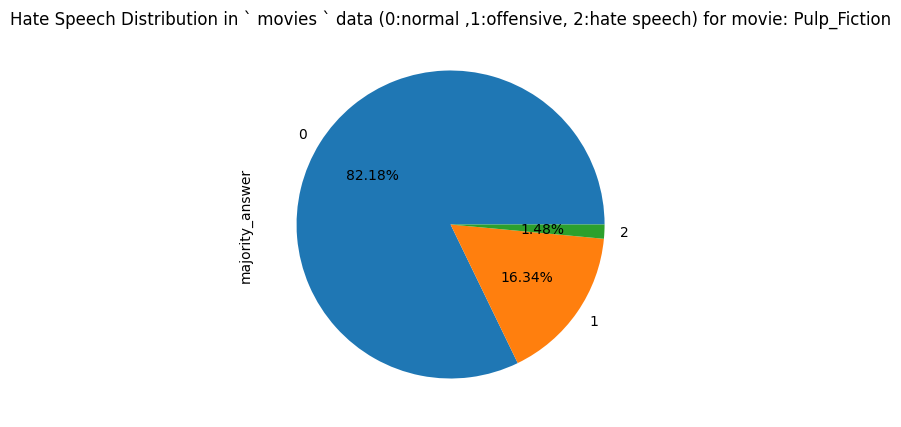

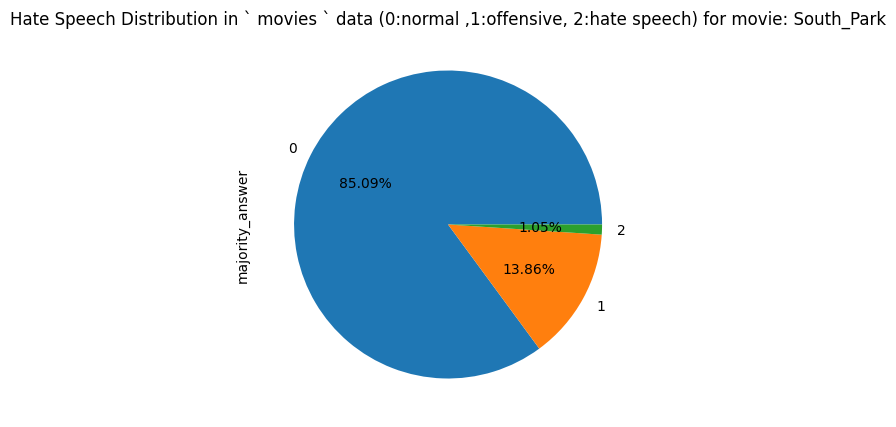

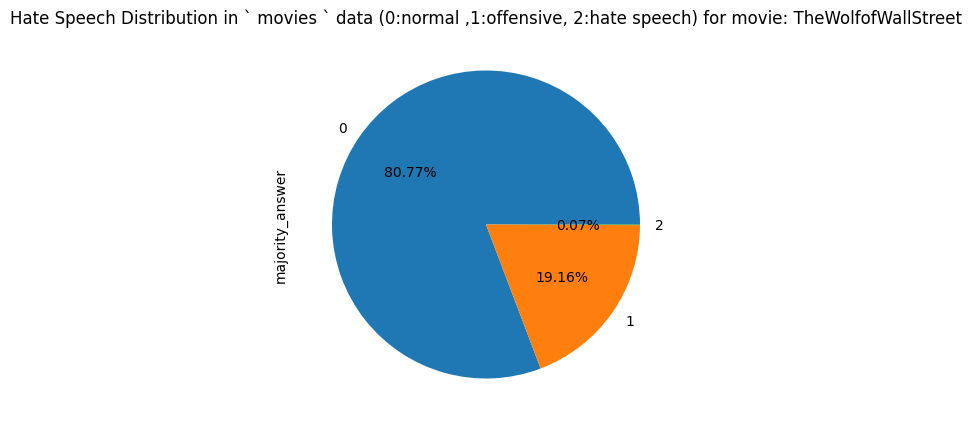

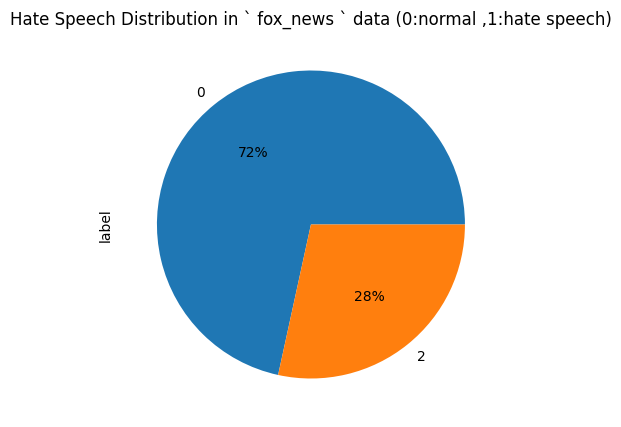

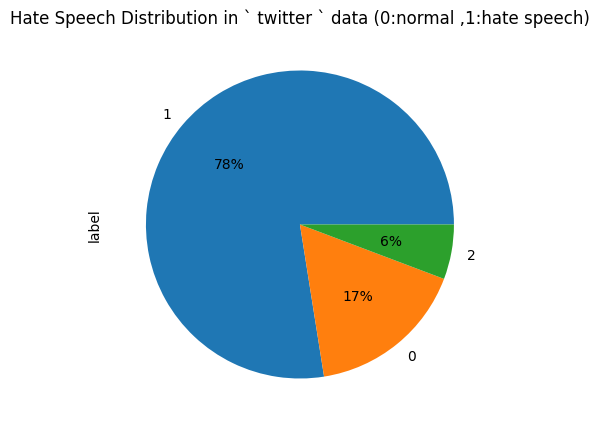

In [3]:
plt.figure(figsize=(10,5))
plt.title('Hate Speech Distribution in ` movies ` data (0:normal ,1:offensive, 2:hate speech)')
movies_data['majority_answer'].value_counts().plot(kind='pie', subplots=True, autopct='%1.0f%%')
plt.show()
# hate speech distribution grouped by movie
for movie in movies_data.movie_name.unique():
    plt.figure(figsize=(10,5))
    plt.title('Hate Speech Distribution in ` movies ` data (0:normal ,1:offensive, 2:hate speech) for movie: '+movie)
    movies_data[movies_data['movie_name']==movie]['majority_answer'].value_counts().plot(kind='pie', subplots=True, autopct='%1.2f%%')
plt.show()
# hate speech and offensive speech are considered as hate speech
plt.figure(figsize=(10,5))
plt.title('Hate Speech Distribution in ` fox_news ` data (0:normal ,1:hate speech)')
fox_news_data['label'].value_counts().plot(kind='pie', subplots=True, autopct='%1.0f%%')
plt.show()
plt.figure(figsize=(10,5))
plt.title('Hate Speech Distribution in ` twitter ` data (0:normal ,1:hate speech)')
twitter_data['label'].value_counts().plot(kind='pie', subplots=True, autopct='%1.0f%%')
plt.show()

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Preparation

In [7]:
def lemmatize_text(text):
    doc = nlp(text)
    lemmatized_words = [token.lemma_ for token in doc]
    return ' '.join(lemmatized_words)
def remove_punctuation_numbers_stopwords(text):
     # Replace numbers and punctuations with spaces
    cleaned_text = re.sub(r'[0-9]+', ' ', text)
    cleaned_text = re.sub(r'[{}]'.format(re.escape(string.punctuation)), ' ', cleaned_text)
    # Remove extra spaces
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    # Remove single-character words
    cleaned_text = ' '.join(word for word in cleaned_text.split() if len(word) > 1)
     # Remove stopwords
    cleaned_text = ' '.join(word for word in cleaned_text.split() if word not in nltk.corpus.stopwords.words('english'))
    return cleaned_text

In [8]:
movies_data_cleaned=movies_data.copy()
movies_data_cleaned['text']=movies_data_cleaned['text'].apply(lambda x: lemmatize_text(x))
movies_data_cleaned['text']=movies_data_cleaned['text'].apply(lambda x: remove_punctuation_numbers_stopwords(x))

fox_news_data_cleaned=fox_news_data.copy()
fox_news_data_cleaned['comment']=fox_news_data_cleaned['comment'].apply(lambda x: lemmatize_text(x))
fox_news_data_cleaned['comment']=fox_news_data_cleaned['comment'].apply(lambda x: remove_punctuation_numbers_stopwords(x))

twitter_data_cleaned=twitter_data.copy()
twitter_data_cleaned['tweet']=twitter_data_cleaned['tweet'].apply(lambda x: lemmatize_text(x))
twitter_data_cleaned['tweet']=twitter_data_cleaned['tweet'].apply(lambda x: remove_punctuation_numbers_stopwords(x))



<p>We assume hate speach and offensive to be the same becaues this would fulfill  the application requirements</p>

In [9]:
# adjust labels to be 1 for hate speech and offensive and 0 for normal
movies_data_cleaned['majority_answer']=movies_data_cleaned['majority_answer'].apply(lambda x: 1 if x==2 else 0)
twitter_data_cleaned['label']=twitter_data_cleaned['label'].apply(lambda x: 1 if x==2 else 0)
fox_news_data_cleaned['label']=fox_news_data_cleaned['label'].apply(lambda x: 1 if x==2 else 0)

In [10]:
print(movies_data_cleaned.head())
print(fox_news_data_cleaned.head())
print(twitter_data_cleaned.head())
movies_data_cleaned.to_csv('movies_data_cleaned.csv',index=False)
fox_news_data_cleaned.to_csv('fox_news_data_cleaned.csv',index=False)
twitter_data_cleaned.to_csv('twitter_data_cleaned.csv',index=False)

                   movie_id         movie_name    batch_id  \
0  AmericanHistoryX(1998)_1  AmerricanHistoryX  1566624979   
1  AmericanHistoryX(1998)_2  AmerricanHistoryX  1566624979   
2  AmericanHistoryX(1998)_3  AmerricanHistoryX  1566624979   
3  AmericanHistoryX(1998)_4  AmerricanHistoryX  1566624979   
4  AmericanHistoryX(1998)_5  AmerricanHistoryX  1566624979   

                          text  majority_answer  
0                        Derek                0  
1                   fuck think                0  
2  black guy outside break car                0  
3                         long                0  
4                         know                0  
                                             comment  label
0                             merkel would never say      1
1  expect woman ask man long interested go touch ...      1
2    grope people public already illegal Deutschland      0
3  merkel possible person charge bad Obama try ha...      1
4  know well mean need pass

# Text Feature Engineering

In [10]:
x1=movies_data_cleaned['text'].values
y1=movies_data_cleaned['majority_answer'].values
x2=twitter_data_cleaned['tweet'].values
y2=twitter_data_cleaned['label'].values
x3=fox_news_data_cleaned['comment'].values
y3=fox_news_data_cleaned['label'].values

In [11]:
x_train = np.hstack((x2, x3))

In [12]:
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
x_train_tfidf = vectorizer.fit_transform(x_train)
x1_tfidf = vectorizer.transform(x1)

In [13]:
from sklearn.decomposition import PCA
n_components = 500  # You can choose the number of components based on your data and computational resources
pca = PCA(n_components=n_components)
x_train_pca = pca.fit_transform(x_train_tfidf.toarray())
x1_pca = pca.transform(x1_tfidf.toarray())

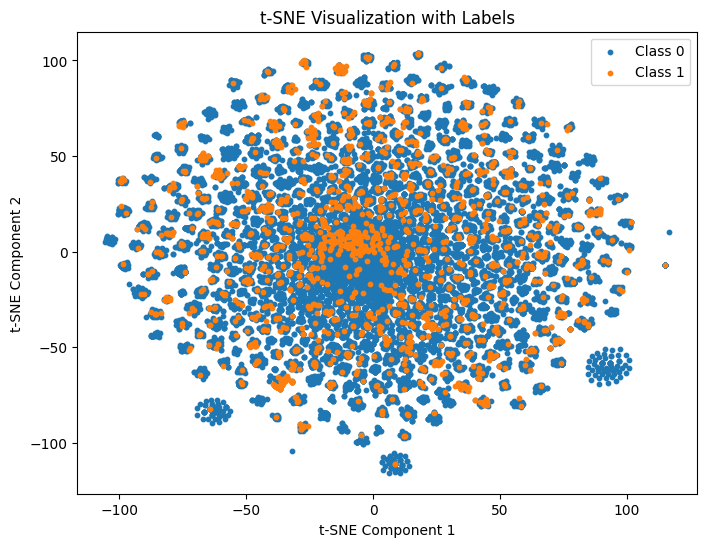

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Step 2: Load your data and labels
data = x_train_pca
labels = np.hstack((y2, y3))

# Step 3: Standardize your data (optional but recommended)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Step 4: Apply t-SNE to your data
tsne = TSNE(n_components=2, random_state=42)
data_tsne = tsne.fit_transform(data_scaled)

# Step 5: Plot the t-SNE results with labels
plt.figure(figsize=(8, 6))
# Loop through each class and plot data points with the corresponding label
for label in np.unique(labels):
    plt.scatter(data_tsne[labels == label, 0], data_tsne[labels == label, 1], label=f'Class {label}', s=10)

plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Visualization with Labels')
plt.legend()
plt.show()


# Clustering

## K-Means

clustring train_data and evaluating validation

In [24]:
kmeans_movies = KMeans(n_clusters=10,n_init='auto').fit(x_train_pca)
print('silhouette score for movies data: ',silhouette_score(x1_pca, y1, metric='euclidean'))

silhouette score for movies data:  0.06553744717926345


 # Classification

## xgboost

              precision    recall  f1-score   support

           0       0.98      0.99      0.99     10394
           1       0.48      0.29      0.36       294

    accuracy                           0.97     10688
   macro avg       0.73      0.64      0.67     10688
weighted avg       0.97      0.97      0.97     10688


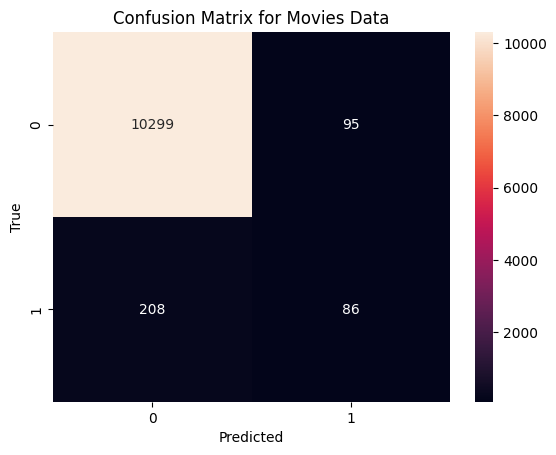

In [16]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


model = XGBClassifier()
model.fit(x_train_pca, np.hstack((y2, y3)))

# Step 6: Evaluate the model on the testing data (after PCA)
y_pred = model.predict(x1_pca)
classification_report_movies=classification_report(y1, y_pred)
print(classification_report_movies)
#plot confusion matrix
confusion_matrix_movies=confusion_matrix(y1, y_pred)
sns.heatmap(confusion_matrix_movies, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Movies Data')
plt.show()

## logisic regression

              precision    recall  f1-score   support

           0       0.98      0.99      0.99     10394
           1       0.55      0.25      0.34       294

    accuracy                           0.97     10688
   macro avg       0.76      0.62      0.67     10688
weighted avg       0.97      0.97      0.97     10688


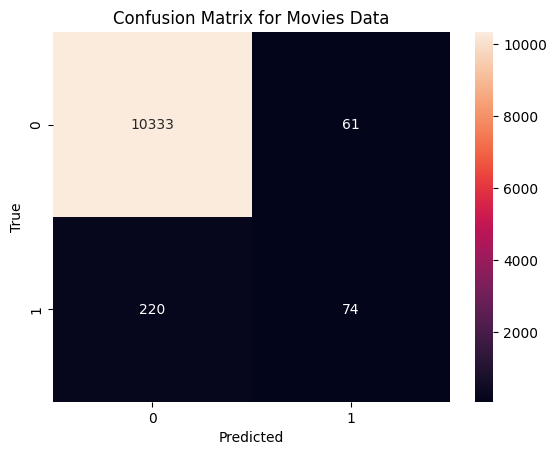

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have already defined the training data (x_train_pca), training labels (y2, y3),
# testing data (x1_pca), and testing labels (y1)

# Step 1: Create a Logistic Regression model
model = LogisticRegression()

# Step 2: Train the model on the training data
model.fit(x_train_pca, np.hstack((y2, y3)))

# Step 3: Make predictions on the testing data (after PCA)
y_pred = model.predict(x1_pca)

# Step 4: Calculate and print the classification report
classification_report_movies = classification_report(y1, y_pred)
print(classification_report_movies)

# Step 5: Plot the confusion matrix
confusion_matrix_movies = confusion_matrix(y1, y_pred)
sns.heatmap(confusion_matrix_movies, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Movies Data')
plt.show()


## bert

In [19]:
! pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 74.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 69.2 MB/s eta 0:00:00


In [20]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                        trainable=True,
                                                        num_labels=2)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
import os
import tensorflow as tf
checkpoint_path = "training_checkpoints/in_domain/all/all.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [32]:
from sklearn.model_selection import train_test_split

def get_dataset(df, seed, test_size):
    return train_test_split(df, test_size=test_size, random_state=seed, shuffle=True)

In [30]:
df_movies=pd.DataFrame({'DATA_COLUMN':x1,'LABEL_COLUMN':y1})
df=pd.DataFrame({'DATA_COLUMN':x_train,'LABEL_COLUMN':np.hstack((y2,y3))})

In [33]:
train, test = get_dataset(df, 11, 0.2)

In [40]:
train.head()

,DATA_COLUMN,LABEL_COLUMN
20708,get something closely approximate full bird pa...,0
6444,omg retard ask weigh thousand pound feather th...,0
25228,Navy Veteran find deplorable happen hold accou...,1
25513,last year Cooke Foundation award million Cooke...,1
24317,stupid bitch,0


In [41]:
def convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN):
  train_InputExamples = train.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN],
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)

  validation_InputExamples = test.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN],
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)

  return train_InputExamples, validation_InputExamples

  train_InputExamples, validation_InputExamples = convert_data_to_examples(train,
                                                                           test,
                                                                           'DATA_COLUMN',
                                                                           'LABEL_COLUMN')

def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = [] # -> will hold InputFeatures to be converted later

    for e in examples:
        # Documentation is really strong for this method, so please take a look at it
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length, # truncates if len(s) > max_length
            return_token_type_ids=True,
            return_attention_mask=True,
            pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
            truncation=True
        )

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
            input_dict["token_type_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label
            )
        )

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )


DATA_COLUMN = 'DATA_COLUMN'
LABEL_COLUMN = 'LABEL_COLUMN'

In [42]:
train_InputExamples, validation_InputExamples = convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN)

train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
train_data = train_data.batch(32)

validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer)
validation_data = validation_data.batch(32)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [43]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-6, epsilon=1e-08, clipnorm=1.0),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

In [44]:
hist = model.fit(train_data, epochs=4, validation_data=validation_data, callbacks=[cp_callback],use_multiprocessing=True)

Epoch 1/4
    650/Unknown - 576s 775ms/step - loss: 0.2343 - accuracy: 0.9293
Epoch 1: saving model to training_checkpoints/in_domain/all/all.ckpt
650/650 [==============================] - 629s 857ms/step - loss: 0.2343 - accuracy: 0.9293 - val_loss: 0.1989 - val_accuracy: 0.9294
Epoch 2/4
650/650 [==============================] - ETA: 0s - loss: 0.1863 - accuracy: 0.9310
Epoch 2: saving model to training_checkpoints/in_domain/all/all.ckpt
650/650 [==============================] - 545s 839ms/step - loss: 0.1863 - accuracy: 0.9310 - val_loss: 0.1921 - val_accuracy: 0.9338
Epoch 3/4
650/650 [==============================] - ETA: 0s - loss: 0.1690 - accuracy: 0.9339
Epoch 3: saving model to training_checkpoints/in_domain/all/all.ckpt
650/650 [==============================] - 554s 853ms/step - loss: 0.1690 - accuracy: 0.9339 - val_loss: 0.1937 - val_accuracy: 0.9350
Epoch 4/4
650/650 [==============================] - ETA: 0s - loss: 0.1562 - accuracy: 0.9383
Epoch 4: saving model to 

In [45]:
preds = model.predict(validation_data)

163/163 [==============================] - 52s 271ms/step


              precision    recall  f1-score      support
0              0.948682  0.983644  0.965847  4830.000000
1              0.582011  0.299728  0.395683   367.000000
accuracy       0.935347  0.935347  0.935347     0.935347
macro avg      0.765346  0.641686  0.680765  5197.000000
weighted avg   0.922789  0.935347  0.925583  5197.000000


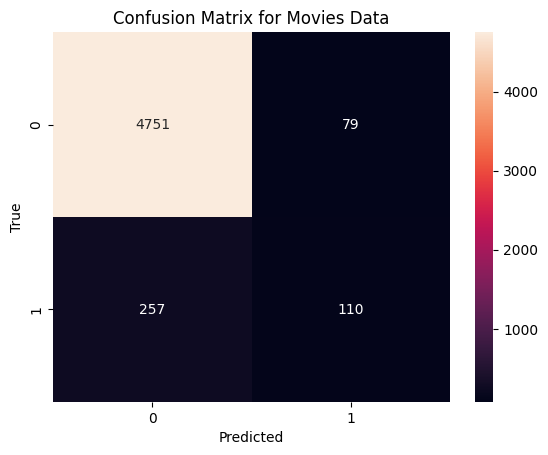

In [51]:
from sklearn.metrics import classification_report, confusion_matrix
cr = classification_report(test['LABEL_COLUMN'],np.argmax(preds[0],axis=1),output_dict=True)
print(pd.DataFrame(cr).transpose()) #  0: Normal speech, 1: Offensive , Hate speech
confusion_matrix_movies = confusion_matrix(test['LABEL_COLUMN'], np.argmax(preds[0],axis=1))
sns.heatmap(confusion_matrix_movies, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Movies Data')
plt.show()

In [53]:
def convert_data_to_examples_valid(data, DATA_COLUMN, LABEL_COLUMN):
  train_InputExamples = data.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN],
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)


  return train_InputExamples

In [54]:
movie_InputExamples = convert_data_to_examples_valid(df_movies, DATA_COLUMN, LABEL_COLUMN)


In [55]:
movie_data = convert_examples_to_tf_dataset(list(movie_InputExamples), tokenizer)
movie_data = movie_data.batch(32)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [76]:
preds_movie = model.predict(movie_data)

334/334 [==============================] - 92s 274ms/step


              precision    recall  f1-score       support
0              0.989346  0.991726  0.990535  10394.000000
1              0.680297  0.622449  0.650089    294.000000
accuracy       0.981568  0.981568  0.981568      0.981568
macro avg      0.834822  0.807087  0.820312  10688.000000
weighted avg   0.980845  0.981568  0.981170  10688.000000


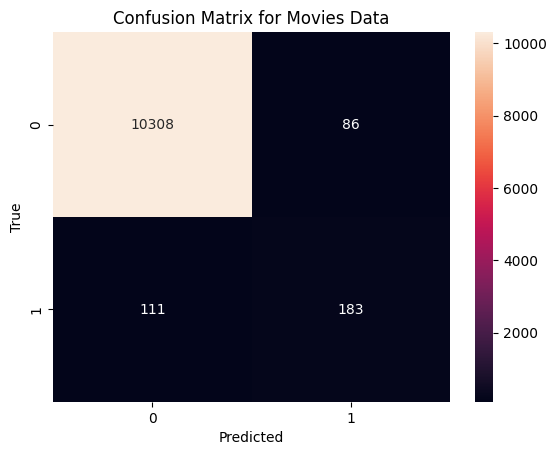

In [77]:
cr_movies = classification_report(df_movies['LABEL_COLUMN'], np.argmax(preds_movie[0], axis=1), output_dict=True)
print(pd.DataFrame(cr_movies).transpose() )# 0: None, 1: offensive,hate
confusion_matrix_movies = confusion_matrix(df_movies['LABEL_COLUMN'], np.argmax(preds_movie[0],axis=1))
sns.heatmap(confusion_matrix_movies, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Movies Data')
plt.show()

In [78]:
# model.save_pretrained('./hateSpeachModel')
# tokenizer.save_pretrained('./hateSpeachModel')

In [127]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures
import transformers
transformers.logging.set_verbosity_error()
loaded_model = TFBertForSequenceClassification.from_pretrained("./hateSpeachModel")
loaded_tokenizer = BertTokenizer.from_pretrained("./hateSpeachModel")

# Replace 'Your input text goes here.' with your actual input text.
input_text = ""
input_text =lemmatize_text(input_text)
input_text =remove_punctuation_numbers_stopwords(input_text)

# Tokenize the input text using the loaded tokenizer
inputs = loaded_tokenizer(input_text, return_tensors="tf")


# Make the prediction
predictions = loaded_model(inputs)

categories={1:'hate',0:'normal'}
print("class:",categories[np.argmax(predictions.logits)])


class: hate


In [136]:
def  predict(model,input_text):

  # Tokenize the input text using the loaded tokenizer
  inputs = loaded_tokenizer(input_text, return_tensors="tf")


  predictions = loaded_model(inputs)

  categories={1:'hate',0:'normal'}
  return categories[np.argmax(predictions.logits)]
  #return np.argmax(predictions.logits)